In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from tqdm import tqdm

# from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
# from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import re

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ratemeter/sample_submission.csv
/kaggle/input/ratemeter/train.csv
/kaggle/input/ratemeter/test.csv


In [4]:
train = pd.read_csv('/kaggle/input/ratemeter/train.csv')
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
0,1c845473e18c23f917126cb29bc8d243,6547260,5805e560deacf886537b2e76b2653515,I finished this in two days. THIS SERIES IS JU...,Sat Nov 16 00:26:42 -0800 2013,Mon Jan 26 11:14:39 -0800 2015,Mon Jan 26 11:14:39 -0800 2015,Sat Jan 24 00:00:00 -0800 2015,0,0,5
1,0867fa7e18da1a292d0256fad0ee4e31,17201095,84c2e89581004bedd01dea2833bed181,Review to follow \n Goodreads 4 \n Amazon 5 \n...,Wed Jan 02 11:22:44 -0800 2013,Sun Apr 28 20:23:22 -0700 2013,NaN,NaN,0,0,5
2,a57237ef712461148672852d8f47e300,16143347,956d4ea003698d83c1495cc251be5bc0,I will have a full review up eventually but fo...,Thu Jun 19 15:48:04 -0700 2014,Thu May 05 09:09:58 -0700 2016,Thu Jun 19 00:00:00 -0700 2014,Thu Jun 19 00:00:00 -0700 2014,0,0,5
3,80589c77f4fa826eaaf7c5d71ff3b81e,7863423,e5ed7e0401cbe5c44e7b7ee4e1af4f09,4 stars. Aww! I loved this one! I have read th...,Wed Sep 16 18:52:06 -0700 2015,Sun Sep 20 18:34:34 -0700 2015,Sun Sep 20 00:00:00 -0700 2015,Sat Sep 19 00:00:00 -0700 2015,1,0,4
4,916977f433fbf96ae9de9669f8aec040,17262303,51b4449f83ff8c9d13a3b6aa2df4fb27,this is official: Patrick Ness is my fav author,Sun Oct 13 11:47:17 -0700 2013,Mon Sep 15 17:51:03 -0700 2014,Tue Sep 16 17:51:03 -0700 2014,NaN,0,0,5


In [5]:
train = train.iloc[:1000]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       1000 non-null   object
 1   book_id       1000 non-null   int64 
 2   review_id     1000 non-null   object
 3   review_text   1000 non-null   object
 4   date_added    1000 non-null   object
 5   date_updated  1000 non-null   object
 6   read_at       892 non-null    object
 7   started_at    670 non-null    object
 8   n_votes       1000 non-null   int64 
 9   n_comments    1000 non-null   int64 
 10  rating        1000 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 86.1+ KB


In [6]:
train.dropna(subset=['read_at','started_at'], inplace=True)
print(train)

                              user_id   book_id  ... n_comments rating
0    1c845473e18c23f917126cb29bc8d243   6547260  ...          0      5
2    a57237ef712461148672852d8f47e300  16143347  ...          0      5
3    80589c77f4fa826eaaf7c5d71ff3b81e   7863423  ...          0      4
5    eaf5eca6017e1e8808f00622737e410f   7735333  ...          0      4
6    dcffeab5847efb63244722253495da06  16068341  ...          0      4
..                                ...       ...  ...        ...    ...
993  b59a9686278c898085548c5756a93ed8  12958487  ...          0      5
994  5be325adbb61fb9d27b4264f6c8737e9  18293427  ...          0      5
996  c191c2691620aa62154c70476b8a1bf5  24612148  ...          0      2
997  f64420f659b8f2283c1328c25431e036   7380117  ...          0      4
999  853414a4aaa2f2de048be926799f14fd   7347109  ...          0      4

[665 rows x 11 columns]


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 665 entries, 0 to 999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       665 non-null    object
 1   book_id       665 non-null    int64 
 2   review_id     665 non-null    object
 3   review_text   665 non-null    object
 4   date_added    665 non-null    object
 5   date_updated  665 non-null    object
 6   read_at       665 non-null    object
 7   started_at    665 non-null    object
 8   n_votes       665 non-null    int64 
 9   n_comments    665 non-null    int64 
 10  rating        665 non-null    int64 
dtypes: int64(4), object(7)
memory usage: 62.3+ KB


In [8]:
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
0,1c845473e18c23f917126cb29bc8d243,6547260,5805e560deacf886537b2e76b2653515,I finished this in two days. THIS SERIES IS JU...,Sat Nov 16 00:26:42 -0800 2013,Mon Jan 26 11:14:39 -0800 2015,Mon Jan 26 11:14:39 -0800 2015,Sat Jan 24 00:00:00 -0800 2015,0,0,5
2,a57237ef712461148672852d8f47e300,16143347,956d4ea003698d83c1495cc251be5bc0,I will have a full review up eventually but fo...,Thu Jun 19 15:48:04 -0700 2014,Thu May 05 09:09:58 -0700 2016,Thu Jun 19 00:00:00 -0700 2014,Thu Jun 19 00:00:00 -0700 2014,0,0,5
3,80589c77f4fa826eaaf7c5d71ff3b81e,7863423,e5ed7e0401cbe5c44e7b7ee4e1af4f09,4 stars. Aww! I loved this one! I have read th...,Wed Sep 16 18:52:06 -0700 2015,Sun Sep 20 18:34:34 -0700 2015,Sun Sep 20 00:00:00 -0700 2015,Sat Sep 19 00:00:00 -0700 2015,1,0,4
5,eaf5eca6017e1e8808f00622737e410f,7735333,1182fe89011626139b42282acb45b1e8,I was impressed! Truly. I felt as if someone w...,Thu Dec 31 07:11:51 -0800 2015,Thu Jan 07 04:46:14 -0800 2016,Sat Jan 02 00:00:00 -0800 2016,Thu Dec 31 00:00:00 -0800 2015,0,0,4
6,dcffeab5847efb63244722253495da06,16068341,fe5b00bc2a14048825a713d744a432ac,I really loved this short little book. \n Alic...,Tue Aug 09 07:25:37 -0700 2016,Wed Aug 10 05:23:03 -0700 2016,Wed Aug 10 05:23:03 -0700 2016,Tue Aug 09 00:00:00 -0700 2016,0,0,4


In [9]:
train['rating'].value_counts()

rating
4    230
5    219
3    142
2     51
1     15
0      8
Name: count, dtype: int64

In [10]:
# Text Lowercasing
train['review_text'] = train['review_text'].str.lower()

In [11]:
# Tokenization
train['review_text'] = train['review_text'].apply(word_tokenize)

In [12]:
# Remove Punctuation and Non-Alphabetic Characters
train['review_text'] = train['review_text'].apply(lambda tokens: [word for word in tokens if word.isalpha()])

In [13]:
# Remove Stopwords
stop_words = set(stopwords.words('english'))
train['review_text'] = train['review_text'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

In [14]:
# lemmatizer = WordNetLemmatizer()
# train['review_text'] = train['review_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [15]:
# Stemmatizing
snow_stemmer = nltk.stem.SnowballStemmer('english')

train['review_text'] = train['review_text'].apply(lambda x: [snow_stemmer.stem(word) for word in x])

In [16]:
#  Reconstruct the Text
train['review_text'] = train['review_text'].apply(lambda tokens: ' '.join(tokens))
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
0,1c845473e18c23f917126cb29bc8d243,6547260,5805e560deacf886537b2e76b2653515,finish two day seri good stop fuck end,Sat Nov 16 00:26:42 -0800 2013,Mon Jan 26 11:14:39 -0800 2015,Mon Jan 26 11:14:39 -0800 2015,Sat Jan 24 00:00:00 -0800 2015,0,0,5
2,a57237ef712461148672852d8f47e300,16143347,956d4ea003698d83c1495cc251be5bc0,full review eventu initi hope thought shake br...,Thu Jun 19 15:48:04 -0700 2014,Thu May 05 09:09:58 -0700 2016,Thu Jun 19 00:00:00 -0700 2014,Thu Jun 19 00:00:00 -0700 2014,0,0,5
3,80589c77f4fa826eaaf7c5d71ff3b81e,7863423,e5ed7e0401cbe5c44e7b7ee4e1af4f09,star aww love one read seri order even though ...,Wed Sep 16 18:52:06 -0700 2015,Sun Sep 20 18:34:34 -0700 2015,Sun Sep 20 00:00:00 -0700 2015,Sat Sep 19 00:00:00 -0700 2015,1,0,4
5,eaf5eca6017e1e8808f00622737e410f,7735333,1182fe89011626139b42282acb45b1e8,impress truli felt someon open eye societi let...,Thu Dec 31 07:11:51 -0800 2015,Thu Jan 07 04:46:14 -0800 2016,Sat Jan 02 00:00:00 -0800 2016,Thu Dec 31 00:00:00 -0800 2015,0,0,4
6,dcffeab5847efb63244722253495da06,16068341,fe5b00bc2a14048825a713d744a432ac,realli love short littl book alic franklin slu...,Tue Aug 09 07:25:37 -0700 2016,Wed Aug 10 05:23:03 -0700 2016,Wed Aug 10 05:23:03 -0700 2016,Tue Aug 09 00:00:00 -0700 2016,0,0,4


In [17]:
def mtn(x):
    months = {'jan': 1,'feb': 2,'mar': 3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
    a = x.strip()[:3].lower()
    month_num = months[a]
    return month_num
    
train['read_at_month'] = train['read_at'].apply(lambda date: mtn(date.split()[1]))
train['read_at_year'] = train['read_at'].apply(lambda date: date.split()[-1])
train['date_added'] = train['date_added'].apply(lambda date: date.split()[-1])
train['date_updated'] = train['date_updated'].apply(lambda date: date.split()[-1])
train['started_at_month'] = train['started_at'].apply(lambda date: mtn(date.split()[1]))
train['started_at_year'] = train['started_at'].apply(lambda date: date.split()[-1])

In [18]:
train = train[['book_id','review_text','date_added','date_updated','n_votes','n_comments','read_at_month','read_at_year','started_at_month','started_at_year','rating']]

In [19]:
train.head()

,book_id,review_text,date_added,date_updated,n_votes,n_comments,read_at_month,read_at_year,started_at_month,started_at_year,rating
0,6547260,finish two day seri good stop fuck end,2013,2015,0,0,1,2015,1,2015,5
2,16143347,full review eventu initi hope thought shake br...,2014,2016,0,0,6,2014,6,2014,5
3,7863423,star aww love one read seri order even though ...,2015,2015,1,0,9,2015,9,2015,4
5,7735333,impress truli felt someon open eye societi let...,2015,2016,0,0,1,2016,12,2015,4
6,16068341,realli love short littl book alic franklin slu...,2016,2016,0,0,8,2016,8,2016,4


In [20]:
train['book_id'] = train['book_id'].astype("int64")
train['date_added'] = train['date_added'].astype("int64")
train['date_updated'] = train['date_updated'].astype("int64")
train['n_votes'] = train['n_votes'].astype("int64")
train['n_comments'] = train['n_comments'].astype("int64")
train['started_at_year'] = train['started_at_year'].astype("int64")
train['read_at_year'] = train['read_at_year'].astype("int64")
train['rating'] = train['rating'].astype("int64")

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 665 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   book_id           665 non-null    int64 
 1   review_text       665 non-null    object
 2   date_added        665 non-null    int64 
 3   date_updated      665 non-null    int64 
 4   n_votes           665 non-null    int64 
 5   n_comments        665 non-null    int64 
 6   read_at_month     665 non-null    int64 
 7   read_at_year      665 non-null    int64 
 8   started_at_month  665 non-null    int64 
 9   started_at_year   665 non-null    int64 
 10  rating            665 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 62.3+ KB


In [22]:
# Open a file and use dump() 
with open('preprocessed.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(train, file) 

In [23]:
# Open the file in binary mode 
with open('preprocessed.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    train = pickle.load(file) 

In [24]:
tfidf = TfidfVectorizer(max_features = 1000, ngram_range=(1,3), analyzer='char')
X = tfidf.fit_transform(train['review_text'])
y = train['rating']

In [25]:
# Open a file and use dump() 
with open('vectorised.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(X, file) 

In [26]:
# Open the file in binary mode 
with open('vectorised.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    X = pickle.load(file) 

In [27]:
print(type(X))
print(type(y))
print(X.shape)
print(y.shape)

<class 'scipy.sparse._csr.csr_matrix'>
<class 'pandas.core.series.Series'>
(665, 1000)
(665,)


In [28]:
print(train['book_id'].shape)

(665,)


In [29]:
# Calculate correlation matrix
correlation_matrix = train[['book_id','date_updated','n_votes','n_comments','read_at_year','started_at_year','rating']].corr()

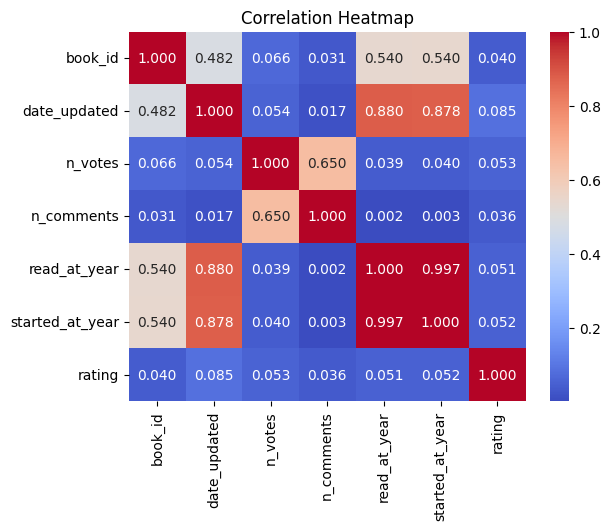

In [30]:
# Plot Heat map
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation Heatmap')
plt.show()

In [31]:
import scipy as sp
from scipy.sparse import csr_matrix

X = sp.sparse.hstack(( X, csr_matrix(train['book_id']).T ))
X = sp.sparse.hstack(( X, csr_matrix(train['date_updated']).T ))
X = sp.sparse.hstack(( X, csr_matrix(train['n_votes']).T ))
X = sp.sparse.hstack(( X, csr_matrix(train['n_comments']).T ))
X = sp.sparse.hstack(( X, csr_matrix(train['read_at_year']).T ))
X = sp.sparse.hstack(( X, csr_matrix(train['started_at_year']).T ))

In [32]:
print(X.shape)
print(X)

(665, 1006)
  (0, 325)	0.08804091067870465
  (0, 34)	0.08468765303770698
  (0, 521)	0.1424004077285839
  (0, 224)	0.0973523504169749
  (0, 43)	0.1279578112958829
  (0, 699)	0.13776837586169202
  (0, 862)	0.09049996836763499
  (0, 107)	0.07534153589272428
  (0, 252)	0.09258195027064325
  (0, 673)	0.11263259574335656
  (0, 696)	0.11381900647335282
  (0, 399)	0.1232094217786616
  (0, 48)	0.08699860758420919
  (0, 443)	0.12125396739142988
  (0, 798)	0.07153547702811419
  (0, 338)	0.09323869579724539
  (0, 839)	0.11101335241693079
  (0, 101)	0.07917318787896956
  (0, 992)	0.14042292100195986
  (0, 194)	0.08525637944281207
  (0, 26)	0.12125396739142988
  (0, 980)	0.14120543018861698
  (0, 926)	0.14970930238290842
  (0, 116)	0.12703579586084437
  (0, 414)	0.14658164860170522
  :	:
  (640, 1005)	2013.0
  (641, 1005)	2014.0
  (642, 1005)	2016.0
  (643, 1005)	2013.0
  (644, 1005)	2010.0
  (645, 1005)	2017.0
  (646, 1005)	2016.0
  (647, 1005)	2016.0
  (648, 1005)	2012.0
  (649, 1005)	2015.0
  (65

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

In [34]:
X_train.shape, y_train.shape

((532, 1006), (532,))

In [35]:
SVC = LinearSVC()
SVC.fit(X_train, y_train)
y_pred_svc = SVC.predict(X_test)
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        29
           4       0.30      0.35      0.32        46
           5       0.27      0.50      0.35        42

    accuracy                           0.28       133
   macro avg       0.09      0.14      0.11       133
weighted avg       0.19      0.28      0.22       133



/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `z

In [ ]:
SVC_balanced = LinearSVC(class_weight='balanced')
SVC_balanced.fit(X_train, y_train)
y_pred_svc_balanced = SVC_balanced.predict(X_test)
print(classification_report(y_test, y_pred_svc_balanced))

In [36]:
#naive bayes classifier
from sklearn.naive_bayes import MultinomialNB

naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)
y_pred_nb = naive_bayes_classifier.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.07      0.50      0.12         4
           1       0.02      0.50      0.03         2
           2       0.11      0.10      0.11        10
           3       0.00      0.00      0.00        29
           4       0.20      0.04      0.07        46
           5       0.24      0.12      0.16        42

    accuracy                           0.08       133
   macro avg       0.11      0.21      0.08       133
weighted avg       0.16      0.08      0.09       133



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
# The maximum number of words to be used. (most frequent)
max_nb_words = 50000

# Max number of words in each complaint.
max_sequence_length = 1006

SyntaxError: invalid non-printable character U+00A0 (1390630963.py, line 7)

In [45]:
aembedding = 100

SyntaxError: invalid non-printable character U+00A0 (2332981794.py, line 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Droupout
from tensorflow.tensorflow.keras.callbacks import EarlyStopping


model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


In [ ]:
test = pd.read_csv('/kaggle/input/ratemeter/test.csv')
test_original = test
test.head()

In [ ]:
# test_original = test_original.iloc[:1000]
# test = test.iloc[:1000]
test.shape

In [ ]:
test.dropna(subset=['read_at','started_at'], inplace=True)
test_original = test
print(test)
print(test.shape)
print(test_original.shape)

In [ ]:
test.info()

In [ ]:
# Text Lowercasing
test['review_text'] = test['review_text'].str.lower()

In [ ]:
test.head()

In [ ]:
# Tokenization
test['review_text'] = test['review_text'].apply(word_tokenize)

In [ ]:
# Remove Punctuation and Non-Alphabetic Characters
test['review_text'] = test['review_text'].apply(lambda tokens: [word for word in tokens if word.isalpha()])

In [ ]:
# Remove Stopwords
stop_words = set(stopwords.words('english'))
test['review_text'] = test['review_text'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

In [ ]:
# Stemmatizing
snow_stemmer = nltk.stem.SnowballStemmer('english')

test['review_text'] = test['review_text'].apply(lambda x: [snow_stemmer.stem(word) for word in x])

In [ ]:
#  Reconstruct the Text
test['review_text'] = test['review_text'].apply(lambda tokens: ' '.join(tokens))

In [ ]:
def mtn(x):
    months = {'jan': 1,'feb': 2,'mar': 3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
    a = x.strip()[:3].lower()
    month_num = months[a]
    return month_num

test['date_added'] = test['date_added'].apply(lambda date: date.split()[-1])
test['date_updated'] = test['date_updated'].apply(lambda date: date.split()[-1])   
test['read_at_month'] = test['read_at'].apply(lambda date: mtn(date.split()[1]))
test['read_at_year'] = test['read_at'].apply(lambda date: date.split()[-1])
test['started_at_month'] = test['started_at'].apply(lambda date: mtn(date.split()[1]))
test['started_at_year'] = test['started_at'].apply(lambda date: date.split()[-1])

In [ ]:
test = test[['book_id','review_text','date_added','date_updated','n_votes','n_comments','read_at_month','read_at_year','started_at_month','started_at_year']]

In [ ]:
test['book_id'] = test['book_id'].astype("int64")
test['date_added'] = test['date_added'].astype("int64")
test['date_updated'] = test['date_updated'].astype("int64")
test['n_votes'] = test['n_votes'].astype("int64")
test['n_comments'] = test['n_comments'].astype("int64")
test['started_at_year'] = test['started_at_year'].astype("int64")
test['read_at_year'] = test['read_at_year'].astype("int64")
test.info()

In [ ]:
test.head()

In [ ]:
# Open a file and use dump() 
with open('preprocessed_test.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(test, file) 

In [ ]:
# Open the file in binary mode 
with open('preprocessed_test.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    test = pickle.load(file) 

In [ ]:
X_t = tfidf.transform(test['review_text'])
# y_t = test['rating']

In [ ]:
# Open a file and use dump() 
with open('vectorised_test.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(X_t, file) 

In [ ]:
# Open the file in binary mode 
with open('vectorised_test.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    X_t = pickle.load(file) 

In [ ]:
print(type(X_t))
print(X_t.shape)

In [ ]:
import scipy as sp
from scipy.sparse import csr_matrix

X_t = sp.sparse.hstack(( X_t, csr_matrix(test['book_id']).T ))
X_t = sp.sparse.hstack(( X_t, csr_matrix(test['date_updated']).T ))
X_t = sp.sparse.hstack(( X_t, csr_matrix(test['n_votes']).T ))
X_t = sp.sparse.hstack(( X_t, csr_matrix(test['n_comments']).T ))
X_t = sp.sparse.hstack(( X_t, csr_matrix(test['read_at_year']).T ))
X_t = sp.sparse.hstack(( X_t, csr_matrix(test['started_at_year']).T ))

In [ ]:
print(type(X_t))
print(X_t.shape)

In [ ]:
y_pred_svc_test = SVC.predict(X_t)
print(y_pred_svc_test)
print("=====")
print(type(y_pred_svc_test))
print("=====")
print(len(y_pred_svc_test))

In [ ]:
y_pred_svc_balanced_test = SVC_balanced.predict(X_t)
print(y_pred_svc_balanced_test)
print("=====")
print(type(y_pred_svc_balanced_test))
print("=====")
print(len(y_pred_svc_balanced_test))

In [ ]:
y_pred_nb_test = naive_bayes_classifier.predict(X_t)
print(y_pred_nb_test)
print("=====")
print(type(y_pred_nb_test))
print("=====")
print(len(y_pred_nb_test))

In [ ]:
review_id_list = test_original['review_id'].to_numpy()
print(review_id_list)
print(type(review_id_list))
# review_id_list(review_id_list.shape)

In [ ]:
data_svc = {'review_id': review_id_list,
        'rating': y_pred_svc_test}


output_df_svc = pd.DataFrame(data_svc)
print(output_df_svc.shape)
output_df_svc.head()

In [ ]:
# saving the dataframe
output_df_svc.to_csv('output_svc.csv',header=True,index=False)

In [ ]:
data_svc_balanced = {'review_id': review_id_list,
        'rating': y_pred_svc_balanced_test}

output_df_svc_balanced = pd.DataFrame(data_svc_balanced)
print(output_df_svc_balanced.shape)
output_df_svc_balanced.head()

In [ ]:
# saving the dataframe
output_df_svc_balanced.to_csv('output_svc_balanced.csv',header=True,index=False)

In [ ]:
data_nb = {'review_id': review_id_list,
        'rating': y_pred_nb_test}

output_df_nb = pd.DataFrame(data_nb)
print(output_df_nb.shape)
output_df_nb.head()

In [ ]:
# saving the dataframe
output_df_nb.to_csv('output_nb.csv',header=True,index=False)